/Users/drew/anaconda3/envs/ts-exp/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           transactions   No. Observations:                   70
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -333.279
Date:                Mon, 04 Dec 2017   AIC                            672.558
Time:                        17:23:08   BIC                            679.303
Sample:                    03-12-2017   HQIC                           675.237
                         - 07-08-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4783      0.186     -2.569      0.010      -0.843      -0.113
ma.L1         -0.1657      0.200     -0.828      0.408      -0.558       0.226
sigma2       912.2338    150.417      6.065      0.000     617.422    1207.046
===================================================================================
Ljung-Box (Q):                       60.34   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.02   Prob(JB):                         0.67
Heteroskedasticity (H):               3.19   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

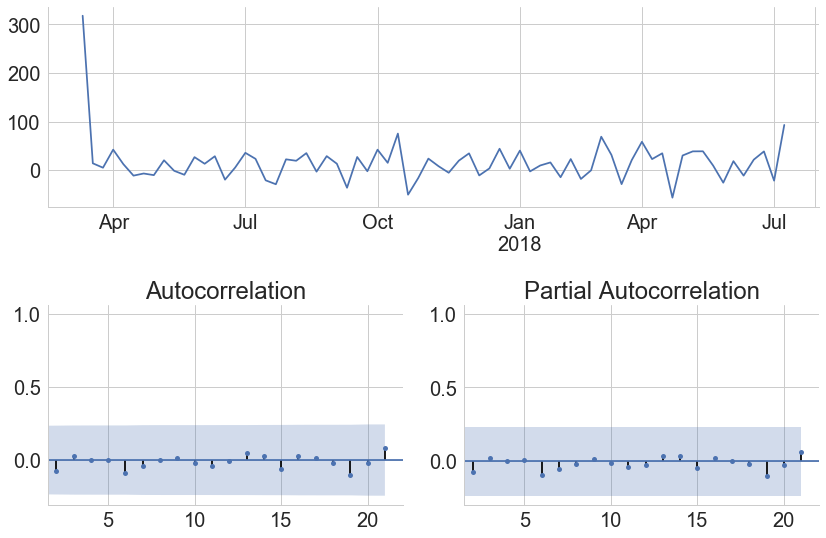

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
from scipy.stats import boxcox, kstest, mstats
from utils import poisson_process, plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

λ = 200  
n = int(100000)  
t0 = pd.to_datetime('2017-03-01') 
freq = '1W'
thinning_components = [
    {'function': poisson_process._trend, 
     'params': {'percent_increase': 1.0, 'period': 365}},
    {'function': poisson_process._cyclical, 
     'params': {'weekday_factor': [1, 1, 1, 1, 1, 0.75, 0.75]}},
    {'function': poisson_process._seasonal, 
     'params': {'peak_time': '09:00:00', 'amplitude': 0.75}}]

nhpp = poisson_process.nhpp(λ, n, t0, freq, thinning_components)

# Add a random normal effect at treatment start, mean=μ_eff, stdev=σ_eff
# This is the interruption,
treatment_start = '2017-10-01'
μ_eff = 0.2
σ_eff = 0.001
response = (pd.Series(nhpp[:pd.to_datetime(treatment_start) - pd.DateOffset(1)])
              .append(
                  np.round(nhpp[treatment_start:] * 
                           (1 + np.random.normal(μ_eff, σ_eff, len(nhpp[treatment_start:]))))))

# Fit the ARIMA and get predictions
mod = smt.SARIMAX(nhpp, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
res = mod.fit()
pred = res.get_prediction(start='2017-03-19', end=max(nhpp.index), dynamic=treatment_start)

# Put everything into a dataframe for convenience
df = (nhpp.to_frame()
          .assign(relative_days=(nhpp.index - pd.to_datetime(treatment_start)).days,
                  prediction=pred.predicted_mean,
                  pred_lower=pred.conf_int().iloc[:, 0],
                  pred_upper=pred.conf_int().iloc[:, 1],
                  response=response)
           .assign(residuals=lambda x: x['transactions'] - x['prediction'],
                   residuals_with_response=lambda x: x['response'] - x['prediction']))

plotting.tsplot(res.resid, lags=21)
res.summary()

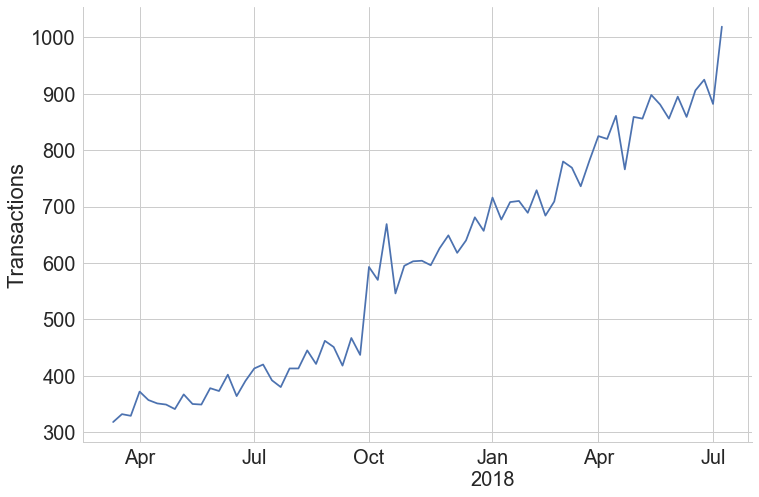

In [3]:
response.plot()
plt.ylabel('Transactions')
sns.despine()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:28<00:00, 88.87it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1e8ff7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1e9fe0f0>]], dtype=object)

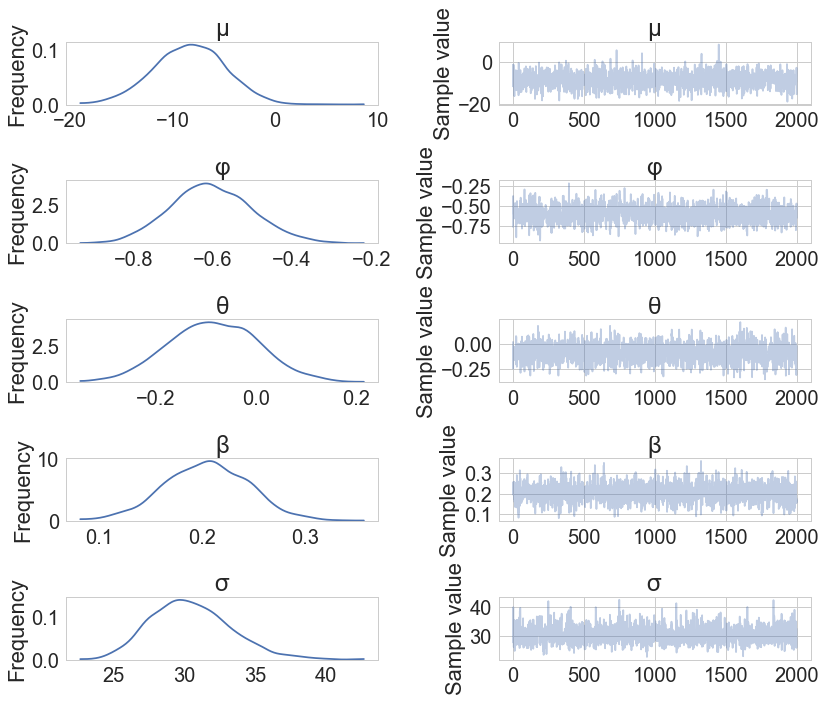

In [4]:
import pymc3 as pm
from theano import scan, shared
import theano.tensor as tt

# (1, 1, 1)
# (φ, _, θ)

def build_model(X, treatment_start):
    y = shared(X.values)
    y_switch = shared(X.index <= treatment_start)
    with pm.Model() as arma_model:
        μ = pm.Normal('μ', 0., sd=10.)
        σ = pm.HalfCauchy('σ', 5.)
        φ = pm.Normal('φ', 0., sd=2.)
        θ = pm.Normal('θ', 0., sd=2.)
        β = pm.Normal('β', 0., sd=2.)
        
        y = tt.switch(y_switch, y, y - tt.dot(y, β))
        
        # (1 - φB) * (1 - B) y[t] = (1 + θB) * ε[t]
        # (1 - B - φB + φB2) y[t] = (1 + θB) * ε[t]
        # ε[t] = y[t] - y[t-1] - φ * y[t-1] + φ * y[t-2] - θ * ε[t-1]
        # ν[t] = y[t] - ε[t]
        # ν[t] = (1 + φ) * y[t-1] - φ * y[t-2] + θ * ε[t-1]
        ε0 = y[0] - μ
        
        def calc_next(y_lag0, y_lag1, y_lag2, ε, μ, φ, θ):
            ν = μ + (1 + φ) * y_lag1 - φ * y_lag2 + θ * ε
            return y_lag0 - ν

        ε, _ = scan(fn=calc_next,
                    sequences=dict(input=y, taps=[-2, -1, 0]),
                    outputs_info=[ε0],
                    non_sequences=[μ, φ, θ])

        pm.Potential('like', pm.Normal.dist(0, sd=σ).logp(ε))
    return arma_model

with build_model(response, treatment_start):
    trace = pm.sample(2000)

pm.traceplot(trace, combined=True)

In [5]:
import pymc3 as pm
import theano.tensor as tt

def linear_regression(X, y):
    with pm.Model() as model:
        w = pm.Flat('w', shape=2)
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

class PyMCModel(object):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

control = df[:treatment_start]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)
fit_control
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 558.94it/s]


array([[  1.27334721,   4.87445719,  -1.67325307, ...,  13.79310088,
        -11.6255669 , -13.17880786],
       [  1.72040345,   4.72313037,  -1.1770965 , ...,  13.93919072,
        -10.73258287, -12.14246056],
       [  2.1674597 ,   4.57180355,  -0.68093993, ...,  14.08528057,
         -9.83959884, -11.10611327],
       ..., 
       [ 31.22611556,  -5.26443958,  31.56923711, ...,  23.58112059,
         48.20436304,  56.25646078],
       [ 31.6731718 ,  -5.4157664 ,  32.06539368, ...,  23.72721043,
         49.09734707,  57.29280807],
       [ 32.12022805,  -5.56709322,  32.56155025, ...,  23.87330028,
         49.99033109,  58.32915536]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 586.53it/s]


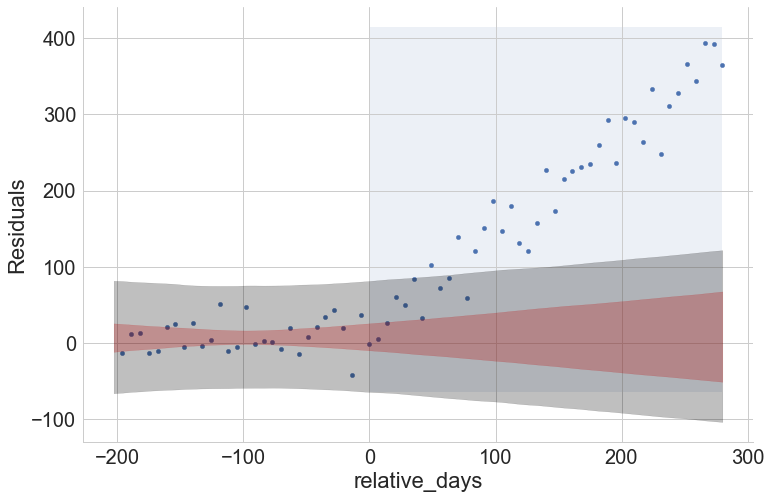

In [103]:
import pymc3 as pm
import theano.tensor as tt

def interrupted_time_series(X, y):
    with pm.Model() as model:
        w = pm.Flat('w', shape=2)
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

class PyMCModel(object):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

control = df[:treatment_start]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)

ax = df.plot(x='relative_days', y='residuals_with_response', kind='scatter')

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), 0, max(df['relative_days']), alpha=.1, zorder=-1)

# Best Fit Control Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_control, q=2.5, axis=1),
                np.percentile(fit_control, q=97.5, axis=1), 
                color='r', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_control - 2 * lr_control.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_control + 2 * lr_control.trace_['σ'], q=97.5, axis=1), 
                color='k', alpha=.25)    

plt.ylabel('Residuals')
sns.despine()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:03<00:00, 781.43it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 97%|█████████▋| 2418/2500 [00:02<00:00, 905.09it/s]/Users/drew/anaconda3/envs/ts-exp/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:02<00:00, 905.88it/s]


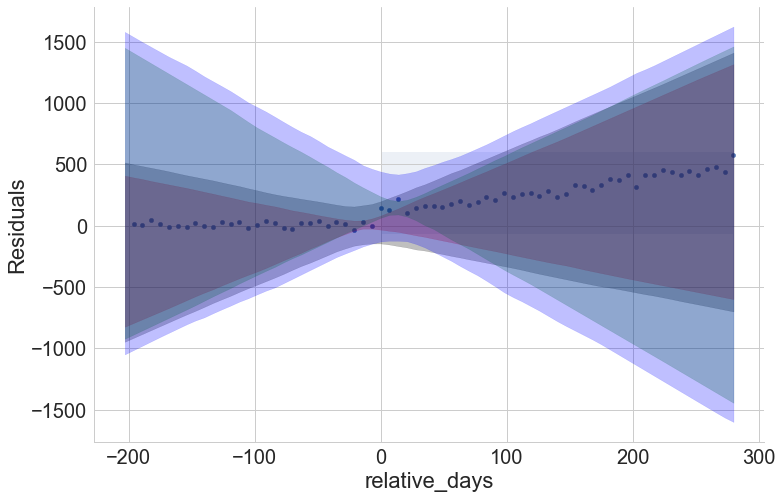

In [17]:
n_days = 5

control = df[:treatment_start][-n_days:]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)

treatment = df[treatment_start:][:n_days]
X_treatment = np.array([np.ones(len(treatment)), treatment['relative_days']]).T
lr_treatment = PyMCModel(linear_regression).fit(X_treatment, treatment['residuals_with_response'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_treatment = lr_treatment.predict(X)

ax = df.plot(x='relative_days', y='residuals_with_response', kind='scatter')

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), 0, max(df['relative_days']), alpha=.1, zorder=-1)

# Best Fit Control Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_control, q=2.5, axis=1),
                np.percentile(fit_control, q=97.5, axis=1), 
                color='r', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_control - 2 * lr_control.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_control + 2 * lr_control.trace_['σ'], q=97.5, axis=1), 
                color='k', alpha=.25)   

# Best Fit Treatment Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_treatment, q=2.5, axis=1),
                np.percentile(fit_treatment, q=97.5, axis=1), 
                color='g', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_treatment - 2 * lr_treatment.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_treatment + 2 * lr_treatment.trace_['σ'], q=97.5, axis=1), 
                color='b', alpha=.25)   

# plt.ylim([-25, 100])
plt.ylabel('Residuals')
sns.despine()

(-4, 5)

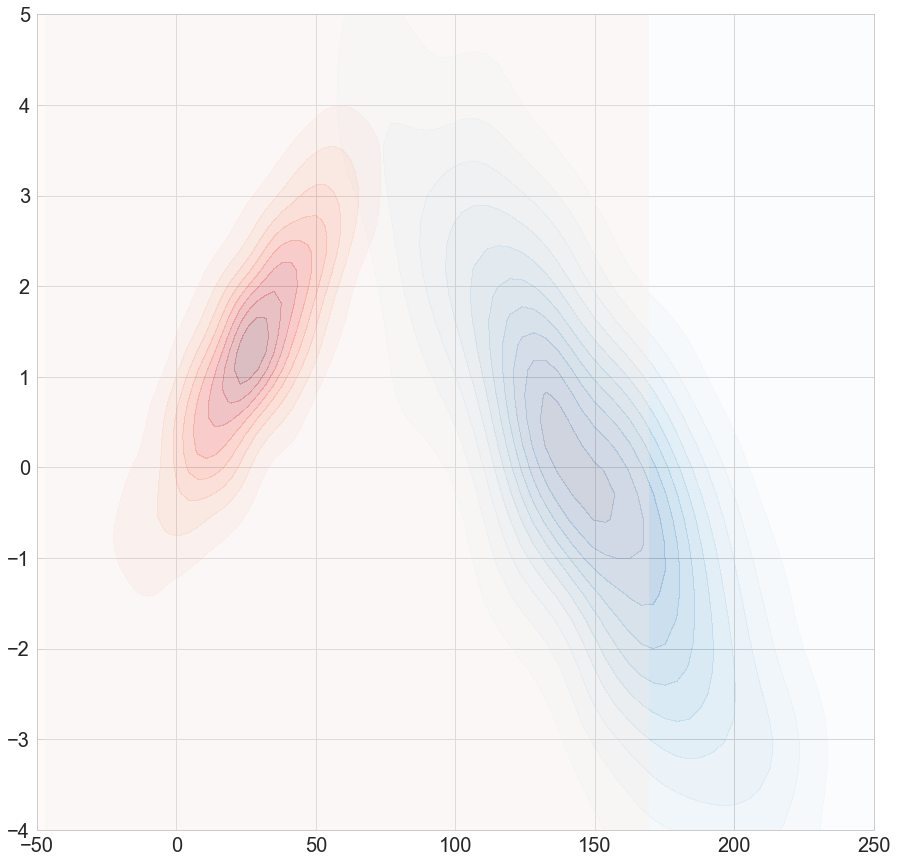

In [22]:
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [15, 15]})
ax = sns.kdeplot(lr_treatment.trace_['w'].T[0], lr_treatment.trace_['w'].T[1], shade=True, cmap='Blues', alpha=0.25)
ax = sns.kdeplot(lr_control.trace_['w'].T[0], lr_control.trace_['w'].T[1], shade=True, cmap='Reds', alpha=0.25)
ax.set_xlim(-50, 250)
ax.set_ylim(-4, 5)